In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()
import ipywidgets
from scipy.signal import butter, lfilter #Import the extra module required
from statsmodels import robust
#Define the filter

In [2]:
dataPath = "C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"

trainOutput = pd.read_csv(dataPath + "challenge_fichier_de_sortie_dentrainement_classification_en_stade_de_sommeil_a_laide_de_signaux_mesures_par_le_bandeau_dreem.csv", sep=";")
Y = trainOutput["label"]

In [3]:
filetrain= dataPath + "train.h5"
filetest= dataPath + "test.h5"
h5 = h5py.File(filetrain, "r")

In [4]:

po_ir = pd.DataFrame(h5['po_ir'][:])
po_r = pd.DataFrame(h5['po_r'][:])


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


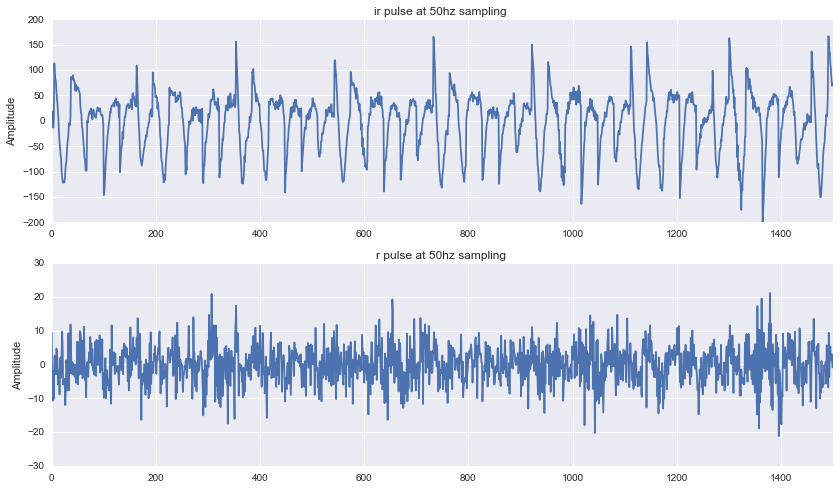

In [20]:
low=0
up= 1500
    
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('ir pulse ' )
ax1.set_ylabel('Amplitude')
ax1.plot(po_ir.iloc[0])
ax1.set_xlim((low, up))
ax1.set_title('ir pulse at 50hz sampling ')

ax2 = fig.add_subplot(212)
ax2.set_title('ir pulse ')
ax2.set_ylabel('Amplitude')
ax2.plot(po_r.iloc[0])
ax2.set_xlim((low, up))
ax2.set_title('r pulse at 50hz sampling ')
fig.show()

used van Gent, P. (2016). Analyzing a Discrete Heart Rate Signal Using Python. A tech blog about fun things with Python and embedded electronics. Retrieved from: http://www.paulvangent.com/2016/03/15/analyzing-a-discrete-heart-rate-signal-using-python-part-1/


Main features are about pulse rate. 
Trying to identify peak in signal

In [5]:
def get_peak(s, viz=False): #s is a serie
    #Calculate moving average with 0.75s in both directions, then append do dataset
    hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
    fs = 50 #The example dataset was recorded at 50Hz (100Hz)
    mov_avg = s.rolling(int(hrw*fs)).mean() #Calculate moving average
    #print(mov_avg)

    avg_hr = np.mean(s)
    mov_avg[np.isnan(mov_avg)] = avg_hr

    mov_avg = mov_avg *1.2  #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, 
    pulse_rollingmean = mov_avg 

    #Mark regions of interest
    window = []
    peaklist = []
    listpos = 0 #We use a counter to move over the different data columns
    for datapoint in s:
        rollingmean = pulse_rollingmean[listpos] #Get local mean
        if (datapoint <= rollingmean) and (len(window) <= 1): #If no detectable R-complex activity -> do nothing
            listpos += 1
        elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
            window.append(datapoint)
            listpos += 1
        else: #If signal drops below local mean -> determine highest point
            maximum = np.max(window)
            beatposition = listpos - len(window) + (window.index(np.max(window))) #Notate the position of the point on the X-axis
            peaklist.append(beatposition) #Add detected peak to list
            window = [] #Clear marked ROI
            listpos += 1
    #print(peaklist)
    
    ybeat = [s[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes
    if (viz):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title("Detected peaks in signal")
        ax1.set_xlim(0,1500)
        ax1.plot(s, alpha=0.5, color='blue') #Plot semi-transparent HR
        ax1.plot(mov_avg, color ='green') #Plot moving average
        ax1.scatter(peaklist, ybeat, color='red') #Plot detected peaks
        fig.show()
    return peaklist

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0

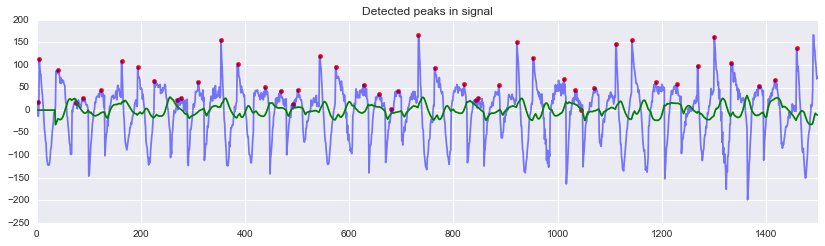

In [22]:
s = po_ir.iloc[0, :]
get_peak(s, viz=True)
0

Signal need to be cleaned before

In [6]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #Nyquist frequeny is half the sampling frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
dataset = po_ir.iloc[0:1, :].copy()
dataset = dataset.T
dataset.columns = ['pulse']

filtered = butter_lowpass_filter(dataset.pulse, 2.5, 50, 5)#filter the signal with a cutoff at 2.5Hz and a 5th order Butterworth filter

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


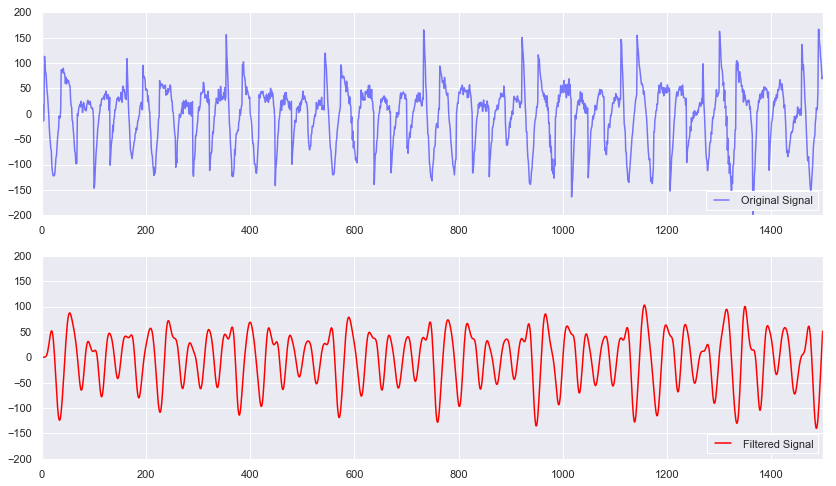

In [8]:
fig = plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.plot(dataset.pulse, color='Blue', alpha=0.5, label='Original Signal')
plt.xlim(0, 1500)
plt.legend(loc=4)
plt.subplot(212)
plt.plot(filtered, color='Red', label='Filtered Signal')
plt.ylim(-200,200) #limit filtered signal to have same y-axis as original (filter response starts at 0 so otherwise the plot will be scaled)
plt.xlim(0, 1500)
plt.legend(loc=4)
fig.show()

We are missing the last peak as the "cycle" was not completed 

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0

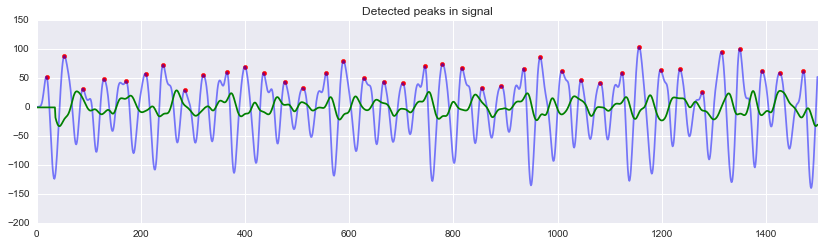

In [26]:
get_peak(pd.Series(filtered), viz=True)
0

Average BPM of an epoch is #peak*2 as an epoch is 30 seconds, so in our exemple. As our peak function can easily miss first and last peak, we have an additional +4/-4 margin of error in BPM

In [9]:
def BPM_filtering(s, viz =False):
    filtered = butter_lowpass_filter(s, 2.5, 50, 5)#filter the signal with a cutoff at 2.5Hz and a 5th order Butterworth filter
    return len(get_peak(pd.Series(filtered), viz=viz))*2

In [20]:
s = po_ir.iloc[1, :]
filtered = butter_lowpass_filter(s, 2.5, 50, 5)
peaks = get_peak(pd.Series(filtered))
print(len(peaks))
print(filtered[peaks].mean())
print(filtered[peaks].std())

40
65.3157767899384
23.301545892484828


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\An

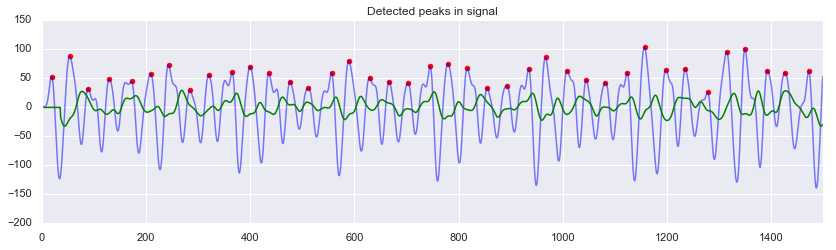

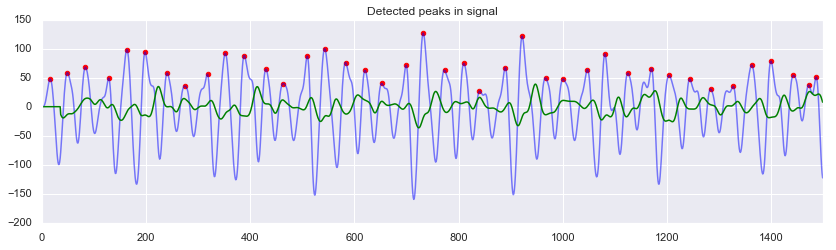

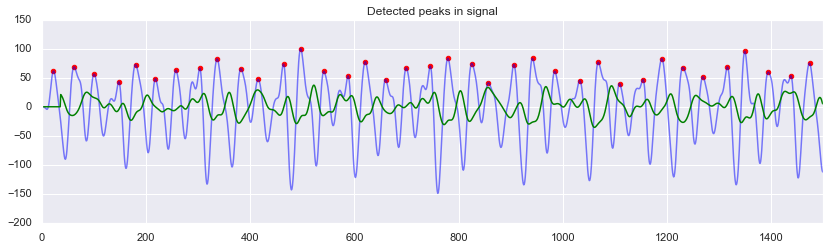

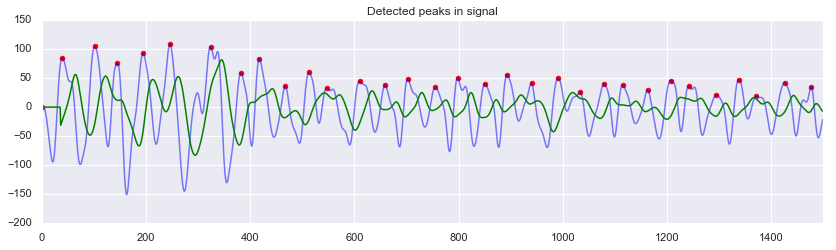

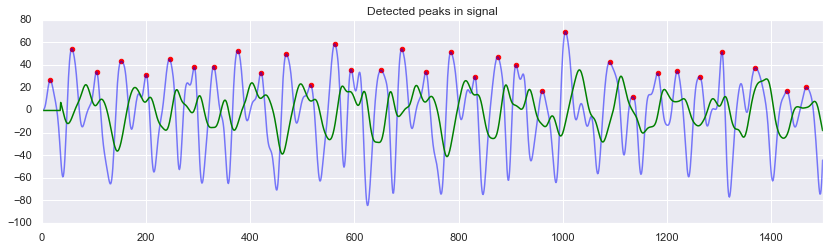

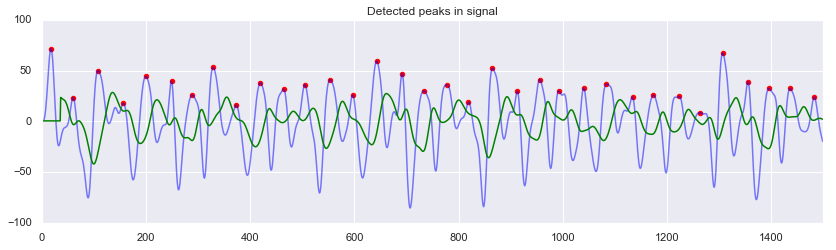

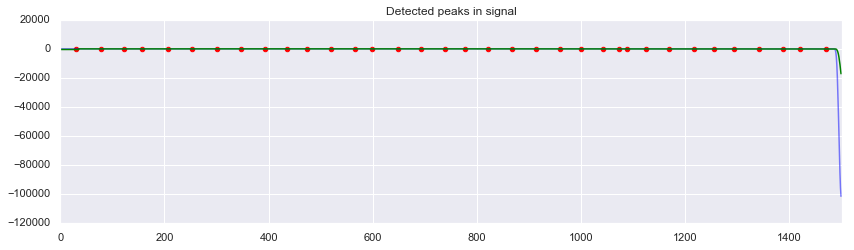

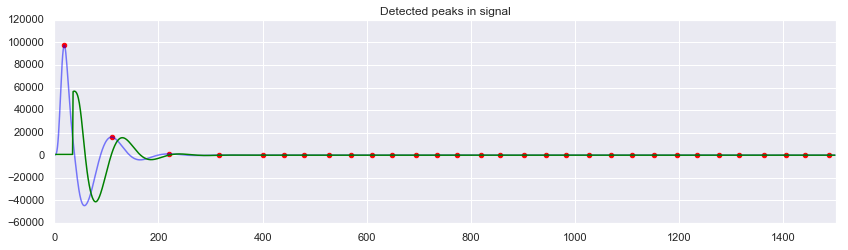

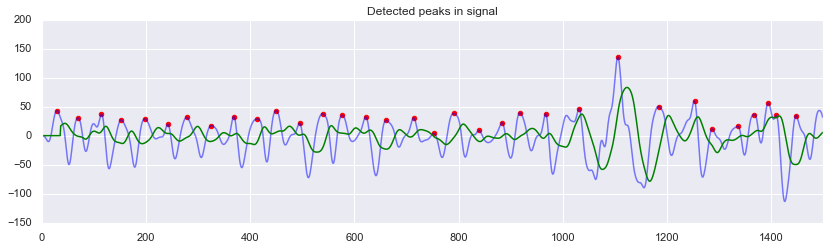

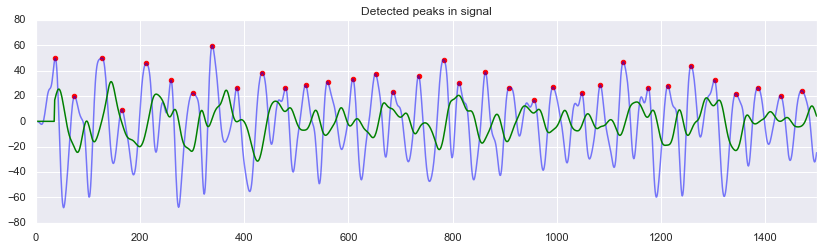

In [10]:
for i in range(0, 10):
    BPM_filtering(po_ir.iloc[i, :], viz=True)

There seems to be a problem with po_ir.iloc[6,:]

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


68

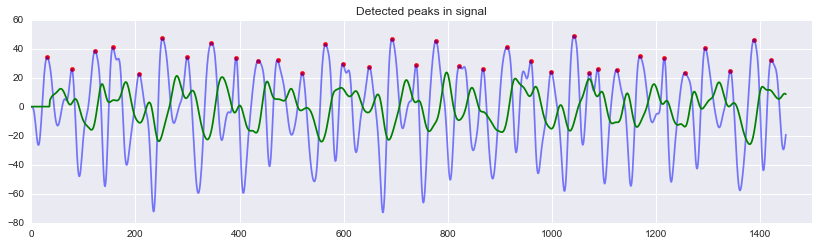

In [29]:
BPM_filtering(po_ir.iloc[6, 0:1450], viz=True)



C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


52

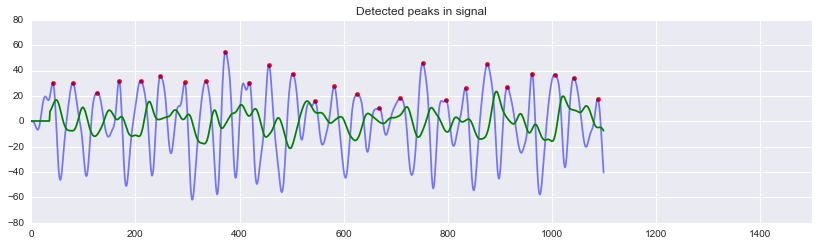

In [31]:
BPM_filtering(po_ir.iloc[7, 400:1500], viz=True)

In [32]:
BPM_filtering(po_ir.iloc[7,:])

62

6 70
7 62


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


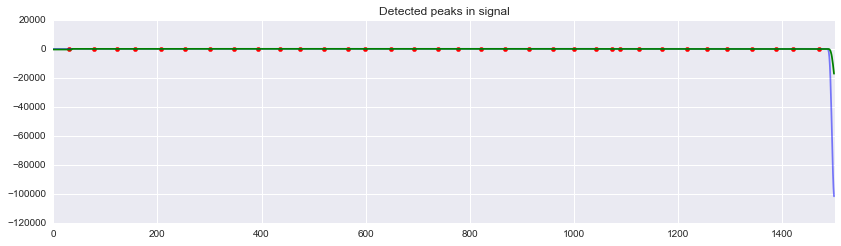

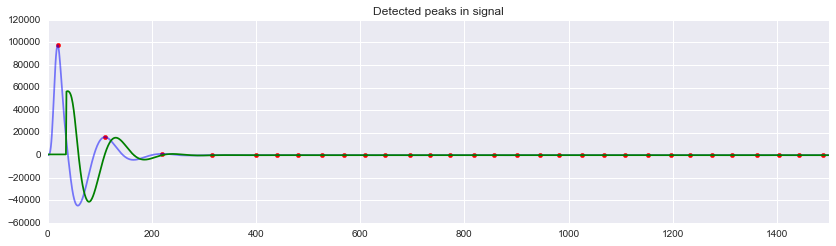

In [33]:
for i in range(0, 10):
    s = po_ir.iloc[i, :]
    if ((s.max() >500) or (s.min() < -500)):
        print(i, BPM_filtering(s, viz=True))
    

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\An

926 64
967 62
969 56
970 64
989 72
991 62


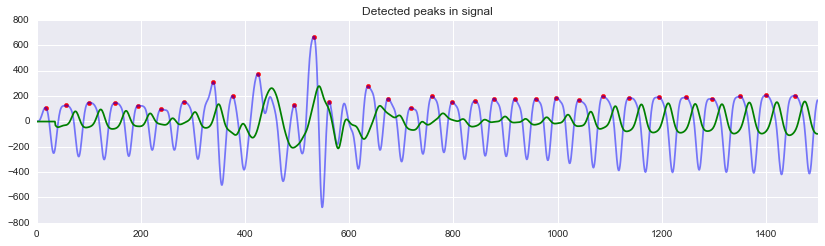

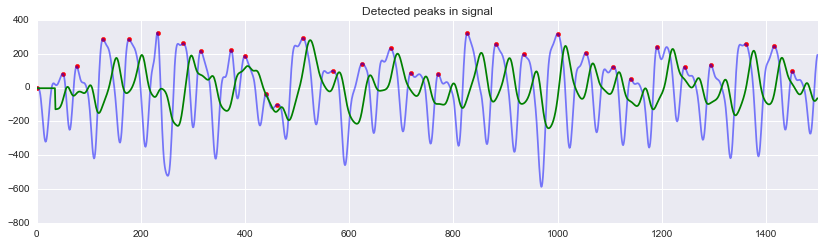

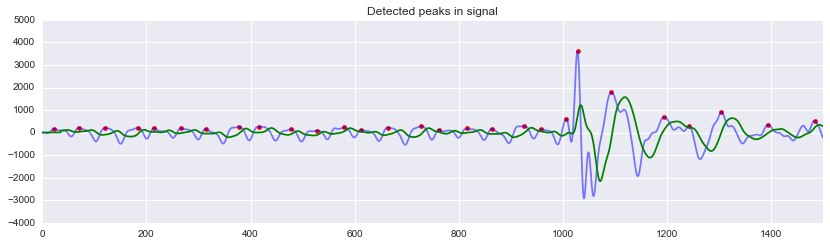

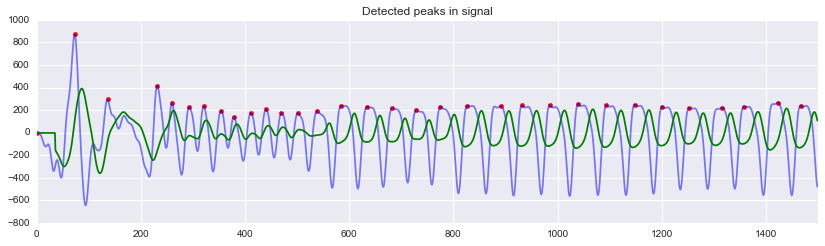

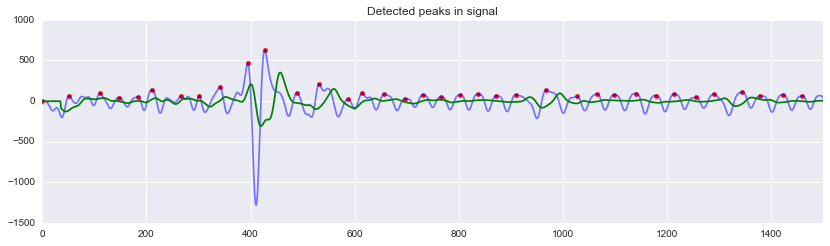

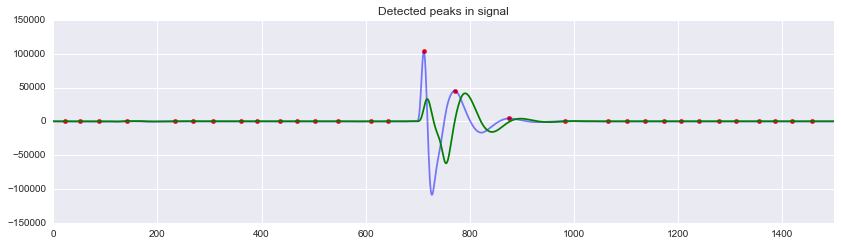

In [34]:
for i in range(900, 1000):
    s = po_ir.iloc[i, :]
    if ((s.max() >500) or (s.min() < -900)):
        print(i, BPM_filtering(s, viz=True))

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


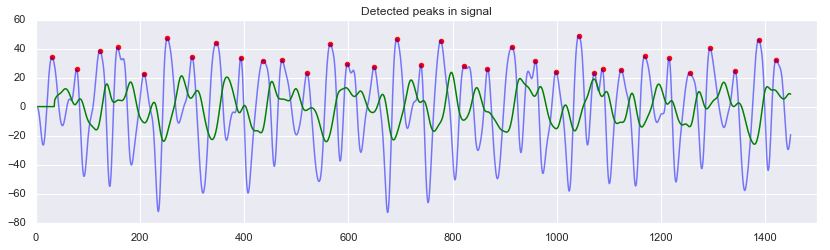

In [12]:
f = BPM_filtering(po_ir.iloc[6, 0:1450], viz=True)

In [35]:
def make_po_ir_features():
    dataPath = "C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"
    filetrain= dataPath + "train.h5"
    filetest= dataPath + "test.h5"
    h5 = h5py.File(filetrain, "r")
    po_ir = pd.DataFrame(h5['po_ir'][:])
    
    features = pd.DataFrame(columns=["BPM", "max", "min"])
    for i in range(0, po_ir.shape[0]):
        s = po_ir.iloc[i, :]
        try:
            features.loc[i, "BPM"] = BPM_filtering(s)
        except Exception as e:
            print("type error: " + str(e))
            print(i)
            return s
            
        features.loc[i, "max"] = s.max()
        features.loc[i, "min"] = s.min()
    return features

In [36]:
toto = make_po_ir_features()

KeyboardInterrupt: 

Display BPM, max and min amplitude for all train data. 
- max BPM arout 120 which is OK
- min BPM should not be under 30. So a features should indicate when it is the case

In [ ]:

    
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(311)
ax1.set_ylabel('BPM per epoch')
ax1.plot(toto["BPM"])
#ax1.set_xlim((low, up))
ax1.set_title('PBM on po_ir ')

ax2 = fig.add_subplot(312)
ax2.set_title('ir pulse ')
ax2.set_ylabel('Amplitude')
ax2.plot(toto["max"])
ax2.set_title('max amplitude by epoch')

ax3 = fig.add_subplot(313)
ax3.set_title('ir pulse ')
ax3.set_ylabel('Amplitude')
ax3.plot(toto["min"])
ax3.set_title('min amplitude by epoch')
fig.show()



Heart Rate Variability” (HRV) measures:
- IBI (inter-beat interval), the mean distance of intervals between heartbeat
- SDNN, the standard deviation of intervals between heartbeats (usually computed on the average of 5 minutes on 24 hours)
- SDSD, the standard deviation of successive differences between adjacent R-R intervals
- RMSSD, the root mean square of successive differences between adjacent R-R intervals:
- pNN50, the number of pairs of successive differences  that differ by more than 50 ms / total number of pairs. As the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not pNN50
- median absolute deviation of RR intervals (MAD)



 IBI = 60 / (BPM(s)) #convers in seconds 
    

In [38]:
def BPM(peak):
    return len(peak)*2

In [45]:


%timeit  filtered = butter_lowpass_filter(po_ir.loc[1, :], 2.5, 50, 5)
%timeit  p= get_peak(pd.Series(filtered))
p= get_peak(pd.Series(filtered))
%timeit BPM(p)
BPM(p)







332 µs ± 4.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
113 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


78

In [46]:

def SDNN(peak):
    RR = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    return pd.Series(RR).std()/50


#%timeit SDNN(p) #divided by sampling frequency to have it in seconds
#SDNN(p)

In [47]:
def SDSD(peak):
    
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    for j in range(1, len(RR)):
        RRdif.append(RR[j]-RR[j-1])
    return pd.Series(RRdif).std()/50



In [48]:

%timeit SDSD(p) 
SDSD(p)

126 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


0.13156028317128277

In [49]:

def RMSSD(peak):
    i=1
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    for j in range(1, len(RR)):
        RRdif.append(RR[j]-RR[j-1])
    r = pd.Series(RRdif)**2
    
    return np.sqrt(r.mean())/50

In [50]:
%timeit RMSSD(p) #divided by sampling frequency to have it in seconds
RMSSD(p)

240 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.12990641121852176

In [51]:
#pNN50, the number of pairs of successive differences that differ by more than 50 ms / total number of pairs
# as the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not p50
def pNN(peak, k):
    #k is the number of tick pNN20 = pNN(s, 1), pNN60(s, 3)
    i=1
    RR = []
    RRdif = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
    l = len(RR)
    count = 0
    for j in range(1, len(RR)):
        if (RR[j]-RR[j-1]) > k:
            count = count +1
    if (l==0):
        result = 0
    else:
        result = count/l
    return result


In [52]:
%timeit pNN(p, 1)
pNN(p, 1)

8.23 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


0.4473684210526316

In [53]:
#median absolute deviation of RR intervals (MAD)

def MAD(peak):
    i=1
    RR = []
    L= peak
    for i in range(1, len(L)):
        RR.append(L[i]-L[i-1])
        
    r = pd.Series(RR)
    return robust.mad(r, c=1)


In [54]:
%timeit MAD(p)
MAD(p)

184 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


3.0

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


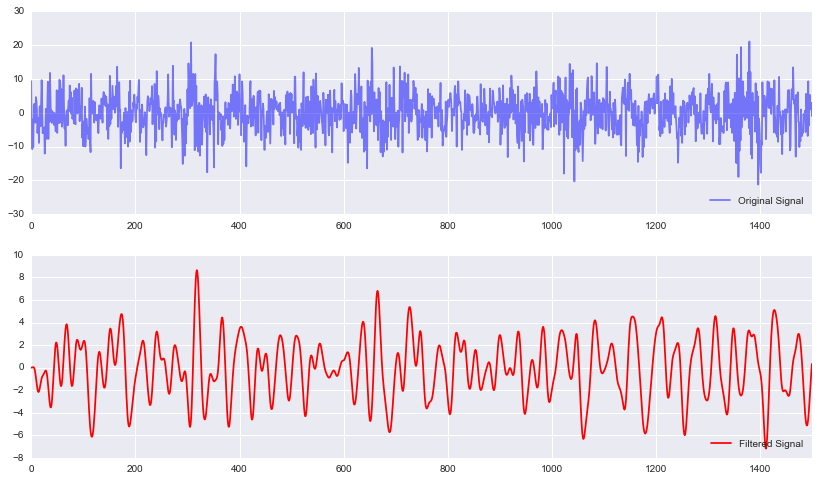

In [56]:
dataset = po_r.iloc[0:1, :].copy()
dataset = dataset.T
dataset.columns = ['pulse']

filtered = butter_lowpass_filter(dataset.pulse, 2.5, 50, 5)#filter the signal with a cutoff at 2.5Hz and a 5th order Butterworth filter

fig = plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.plot(dataset.pulse, color='Blue', alpha=0.5, label='Original Signal')
plt.xlim(0, 1500)
plt.legend(loc=4)
plt.subplot(212)
plt.plot(filtered, color='Red', label='Filtered Signal')
#plt.ylim(-200,200) #limit filtered signal to have same y-axis as original (filter response starts at 0 so otherwise the plot will be scaled)
plt.xlim(0, 1500)
plt.legend(loc=4)
fig.show()

In [57]:
def compare_sensors():
    
    features = pd.DataFrame(columns=["BPM_ir", "BPM_r"])
    for i in range(0, po_ir.shape[0]):
        features.loc[i, "BPM_ir"] =BPM_filtering(po_ir.iloc[i, :])
        features.loc[i, "BPM_r"] =BPM_filtering(po_r.iloc[i, :])         
    return features
                                     
                                     

In [58]:
toto = compare_sensors()





C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


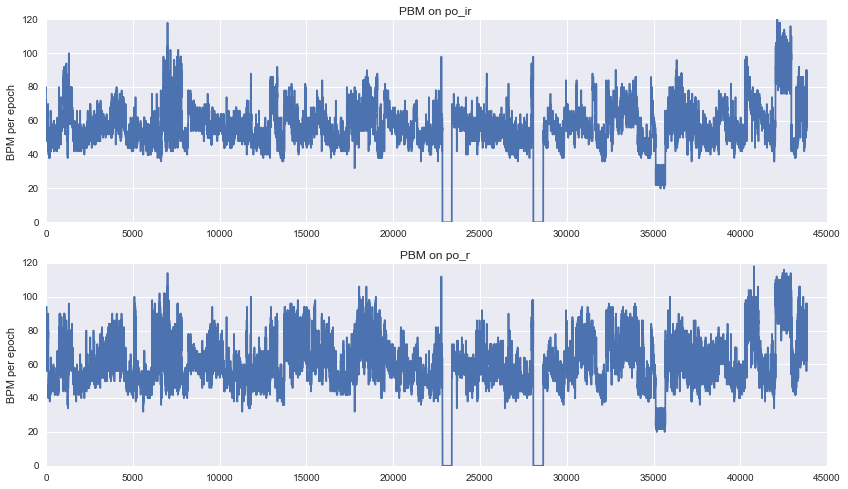

In [59]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_ylabel('BPM per epoch')
ax1.plot(toto["BPM_ir"])
#ax1.set_xlim((low, up))
ax1.set_title('PBM on po_ir ')

ax2 = fig.add_subplot(212)
ax2.set_ylabel('BPM per epoch')
ax2.plot(toto["BPM_r"])
#ax1.set_xlim((low, up))
ax2.set_title('PBM on po_r ')

fig.show()

Text(0.5,1,'Delta BPM/sensor per epoch ')

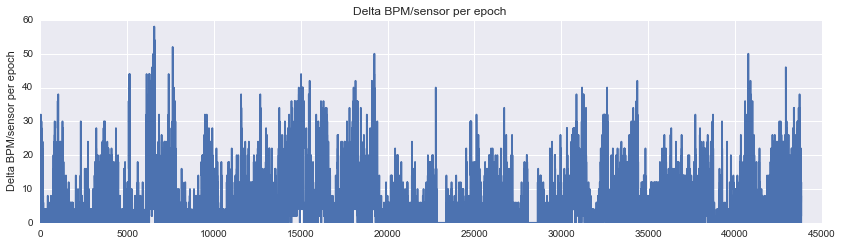

In [60]:
delta = np.abs(toto["BPM_r"]- toto["BPM_ir"])
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_ylabel(' Delta BPM/sensor per epoch')
ax1.plot(delta)
#ax1.set_xlim((low, up))
ax1.set_title('Delta BPM/sensor per epoch ')

print("|ir-r|.BPM median", delta.median())
print("|ir-r|.BPM mean", delta.mean())
print("|ir-r|.BPM std", delta.std())


Note going into sensor data fusing
- lack of time
- convolution NN are suposed to be able to take care of this 

Text(0.5,1,'|ir -r|.bpm hitogram ')

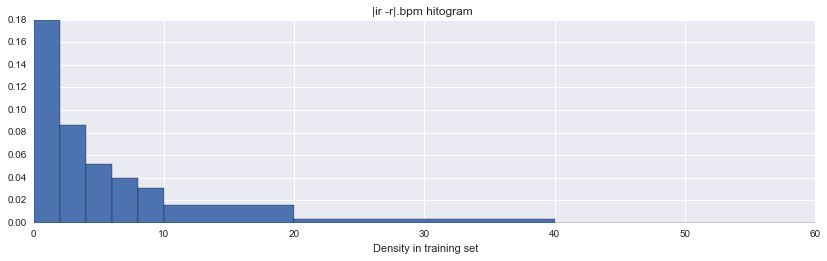

In [64]:


fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_xlabel(' |ir -r|.bpm')
ax1.set_xlabel(' Density in training set')
plt.hist(delta, bins=[0,  2, 4, 6, 8, 10, 20, 40, 60], density = True)
#ax1.set_xlim((low, up))
ax1.set_title('|ir -r|.bpm hitogram ')

In [ ]:

    IBI (inter-beat interval), the mean distance of intervals between heartbeat
    SDNN, the standard deviation of intervals between heartbeats (usually computed on the average of 5 minutes on 24 hours)
    SDSD, the standard deviation of successive differences between adjacent R-R intervals
    RMSSD, the root mean square of successive differences between adjacent R-R intervals:
    pNN50, the number of pairs of successive differences that differ by more than 50 ms / total number of pairs. As the sampling rate is 50hz, 20 ms differences is on "tick" and we can have pNN60 but not pNN50
    MAD: median absolute deviation of RR intervals (MAD)


In [23]:
s = po_ir.iloc[1, :]
filtered = butter_lowpass_filter(s, 2.5, 50, 5)
peaks = get_peak(pd.Series(filtered))
print(len(peaks))
print(filtered[peaks].mean())
print(filtered[peaks].std())


40
65.3157767899384
23.301545892484828


In [24]:
def make_pulse_amplitude(h5filename, dataPath="C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"):
    print("Read data")
    h5file= dataPath + h5filename
    h5 = h5py.File(h5file, "r")
    po_ir = pd.DataFrame(h5['po_ir'][:])
    po_r = pd.DataFrame(h5['po_r'][:])   
    features = pd.DataFrame(
        columns=["amp_mean_ir", "amp_std_ir", "amp_mean_r", "amp_std_r"])
    
    print("start po_ir")
    for i in range(0, po_ir.shape[0]):
        filtered = butter_lowpass_filter(po_ir.loc[i, :], 2.5, 50, 5)
        peaks = get_peak(pd.Series(filtered))
        features.loc[i, "amp_mean_ir"]=filtered[peaks].mean()
        features.loc[i, "amp_std_ir"]=filtered[peaks].std()
     
    print("start po_r")
    for i in range(0, po_ir.shape[0]):
        filtered = butter_lowpass_filter(po_r.loc[i, :], 2.5, 50, 5)
        peaks = get_peak(pd.Series(filtered))
        features.loc[i, "amp_mean_r"]=filtered[peaks].mean()
        features.loc[i, "amp_std_r"]=filtered[peaks].std()
    return features

In [75]:
def make_pulse_features(h5filename, dataPath="C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"):
    print("Read data")
    h5file= dataPath + h5filename
    h5 = h5py.File(h5file, "r")
    po_ir = pd.DataFrame(h5['po_ir'][:])
    po_r = pd.DataFrame(h5['po_r'][:])
    
    features = pd.DataFrame(
        columns=["BPM_ir", "IBI_ir", "SDNN_ir", "SDSD_ir", "RMSSD_ir", "pNN60_ir", "pNN20_ir", "MAD_ir", "BPMlessthan30_ir", "max_ir", "min_ir",
                 "BPM_r", "IBI_r", "SDNN_r", "SDSD_r", "RMSSD_r", "pNN60_r", "pNN20_r", "MAD_r", "BPMlessthan30_r", "max_r", "min_r"])
    
    print("start po_ir")
    for i in range(0, po_ir.shape[0]):
        filtered = butter_lowpass_filter(po_ir.loc[i, :], 2.5, 50, 5)
        s = get_peak(pd.Series(filtered))
        _bpm = BPM(s)
        if (_bpm >= 30):
            features.loc[i, "BPM_ir"] = _bpm
            features.loc[i, "IBI_ir"] = 60/_bpm
            features.loc[i, "SDNN_ir"] = SDNN(s)
            features.loc[i, "SDSD_ir"] = SDSD(s)
            features.loc[i, "RMSSD_ir"] = RMSSD(s)
            features.loc[i, "pNN60_ir"] = pNN(s, 3)
            features.loc[i, "pNN20_ir"] = pNN(s, 1)
            features.loc[i, "MAD_ir"] = MAD(s)
            features.loc[i, "BPMlessthan30_ir"] = 0                
        else:
            features.loc[i, "BPM_ir"] = 0
            features.loc[i, "IBI_ir"] = 0
            features.loc[i, "SDNN_ir"] = 0
            features.loc[i, "SDSD_ir"] = 0
            features.loc[i, "RMSSD_ir"] = 0
            features.loc[i, "pNN60_ir"] = 0
            features.loc[i, "pNN20_ir"] = 0
            features.loc[i, "MAD_ir"] = 0
            features.loc[i, "BPMlessthan30_ir"] = 1
            
        features.loc[i, "max_ir"] = filtered.max() #when amplitude goes too high due to measurement issue, it somewhat scramble bpm 
        features.loc[i, "min_ir"] = filtered.min()
       
    print("start po_r")
    for i in range(0, po_ir.shape[0]):
        filtered = butter_lowpass_filter(po_r.loc[i, :], 2.5, 50, 5)
        s = get_peak(pd.Series(filtered))
        _bpm = BPM(s)
        if (_bpm >= 30):
            features.loc[i, "BPM_r"] = _bpm
            features.loc[i, "IBI_r"] = 60/_bpm
            features.loc[i, "SDNN_r"] = SDNN(s)
            features.loc[i, "SDSD_r"] = SDSD(s)
            features.loc[i, "RMSSD_r"] = RMSSD(s)
            features.loc[i, "pNN60_r"] = pNN(s, 3)
            features.loc[i, "pNN20_r"] = pNN(s, 1)
            features.loc[i, "MAD_r"] = MAD(s)
            features.loc[i, "BPMlessthan30_r"] = 0    
        else:
            features.loc[i, "BPM_r"] = 0
            features.loc[i, "IBI_r"] = 0
            features.loc[i, "SDNN_r"] = 0
            features.loc[i, "SDSD_r"] = 0
            features.loc[i, "RMSSD_r"] = 0
            features.loc[i, "pNN60_r"] = 0
            features.loc[i, "pNN20_r"] = 0
            features.loc[i, "MAD_r"] = 0
            features.loc[i, "BPMlessthan30_r"] = 1            
            
        features.loc[i, "max_r"] = filtered.max()
        features.loc[i, "min_r"] = filtered.min()
    return features

In [25]:
amp_train = make_pulse_amplitude("train.h5")
amp_train.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_ampTrain.csv')

Read data
start po_ir


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


start po_r


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.


In [26]:
amp_test =make_pulse_amplitude("test.h5")
amp_test.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_ampTest.csv')

Read data
start po_ir


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


start po_r


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.


In [66]:
#pulse_train = make_pulse_features("train.h5")
#pulse_train.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.xlsx')



In [78]:
#pulse_train.shape
pulse_train = make_pulse_features("train.h5")
pulse_train.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')

Read data
start po_ir
start po_r


In [76]:
pulse_test = make_pulse_features("test.h5")
pulse_test.to_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTest.csv')


Read data
start po_ir
start po_r


In [77]:
pd.isna(pulse_test).any()

BPM_ir              False
IBI_ir              False
SDNN_ir             False
SDSD_ir             False
RMSSD_ir            False
pNN60_ir            False
pNN20_ir            False
MAD_ir              False
BPMlessthan30_ir    False
max_ir              False
min_ir              False
BPM_r               False
IBI_r               False
SDNN_r              False
SDSD_r              False
RMSSD_r             False
pNN60_r             False
pNN20_r             False
MAD_r               False
BPMlessthan30_r     False
max_r               False
min_r               False
dtype: bool